In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import scipy.io 

import laplace
%matplotlib inline
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class Network(torch.nn.Module):
    def __init__(self,layers,non_linear):
        super(Network, self).__init__()
        self.layers=layers
        self.non_linear=non_linear
        
        self.HiddenLayers = torch.nn.ModuleList()
        self.HiddenLayersNon = []
        
        for i in range(len(self.layers)-2):
            self.HiddenLayers.append(torch.nn.Linear(layers[i], layers[i+1]))
            self.HiddenLayersNon.append(self.non_linear);

        self.readout = torch.nn.Linear(self.layers[-2], self.layers[-1])

    def forward(self, x):
        for hiddenLayer, hiddenLayernon in zip(self.HiddenLayers, self.HiddenLayersNon):
            x = hiddenLayer(x)
            x = hiddenLayernon(x)
        return self.readout(x)

In [4]:
#Helper functions
from torch.utils.data import Dataset, DataLoader
def diff(u,x,order=1):
    grad = torch.autograd.grad(u.sum(),x,create_graph=True)[0]
    for i in range(1,order):
        grad = torch.autograd.grad(grad.sum(),x,create_graph=True)[0]
    return grad

def running_mean(x, N=50):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    def __len__(self):
        
        return len(self.data)

def loader(x,t,u,batch_size=None,train=True,augm_flag=True):
    if batch_size==None:
        batch_size=x.shape[0]
    dataset=MyDataset(data=torch.hstack([x[:,None],t[:,None]]).squeeze(),targets=u)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [5]:
def f_u(x,t,net):
    _device = next(net.parameters()).device
    x=x.to(_device)
    t=t.to(_device)
    input = torch.hstack([x,t]).requires_grad_().to(_device)
    u = net(input)
    u_x = diff(u,x)
    u_t = diff(u,t)
    u_xx = diff(u_x,x)
    return (u_t + u*u_x - (0.01/np.pi)*u_xx)

In [6]:
def f_test(x,net):
    _device = next(net.parameters()).device
    x=x.to(_device).requires_grad_()
    x0=x[:,0,None]
    x1=x[:,1,None]
    input = torch.hstack([x0,x1]).requires_grad_().to(_device)
    #input = x.requires_grad_().to(_device)
    u = net(input)
    u_x = diff(u,x0)
    u_t = diff(u,x1)
    u_xx = diff(u_x,x0)
    return (u_t + u*u_x - (0.01/np.pi)*u_xx)


In [7]:
def b_u(x,t,net):
    _device = next(net.parameters()).device
    x=x.to(_device)
    t=t.to(_device)
    input = torch.hstack([x,t]).requires_grad_().to(_device)
    u=net(input)
    u_star=torch.as_tensor([-torch.sin(i*np.pi) if j==0 else 0. for i,j in zip(x,t)])[:,None].to(_device)
    return u-u_star

In [8]:
data = scipy.io.loadmat('./burgers_shock.mat')
t_ = torch.tensor(data['t'].flatten()).float()
x_ = torch.tensor(data['x'].flatten()).float()
Exact = np.real(data['usol']).T

#X,T=torch.meshgrid(x_,t_,indexing='xy')
#X,T=torch.meshgrid(x_,t_)
X,T=np.meshgrid(x_,t_,indexing='xy')
X=torch.tensor(X)
T=torch.tensor(T)
X_exact=X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_exact = Exact.flatten()[:,None]              

In [9]:
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
def plot_burger(Y,plot_points=True,normcenter=None):
    if normcenter is not None:
        divnorm=colors.TwoSlopeNorm(vcenter=normcenter)
        cm='coolwarm'
    else:
        divnorm=None
        cm='rainbow'
    plt.figure(dpi=120,figsize=(9,11))
    U_std = griddata(X_exact, Y.flatten(), (X, T), method='nearest')
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(((U_std)).T, interpolation='nearest', cmap=cm,norm=divnorm, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    if plot_points:
        ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)

In [10]:
t = torch.linspace(0,1,251).float()
x = torch.linspace(-1,1,501).float()
bc_l=torch.vstack([-1*torch.ones_like(t),t]).T
bc_r=torch.vstack([torch.ones_like(t),t]).T
ic=torch.vstack([x,torch.zeros_like(x)]).T
data_grid=torch.vstack([bc_l,bc_r,ic])
x=data_grid[:,0]
t=data_grid[:,1]
#X,T=torch.meshgrid(x,t,indexing='xy')
u_star=torch.as_tensor([-np.sin(i[0]*np.pi) if i[1]==0 else 0. for i in data_grid])[:,None]

In [11]:
#model = Network([2, 20, 20, 20, 20, 20, 20, 20, 1],torch.nn.Tanh()).to(device)
model = Network([2,16,16,16,16,1],torch.nn.Tanh()).to(device)
'''
model = torch.nn.Sequential(
    torch.nn.Linear(2, 16), torch.nn.Tanh(),
    torch.nn.Linear(16, 16), torch.nn.Tanh(),
    torch.nn.Linear(16, 16), torch.nn.Tanh(),
    torch.nn.Linear(16, 1)).to(device)
'''

#model = Network([2,20,20,20,20,1],torch.nn.Tanh()).to(device)

mse = torch.nn.MSELoss(reduction='sum') 
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-2)

iters=30000
#N_data=2000
N_col=1000
use_grid=False

train_error=[]
test_error=[]
mse_fs=[]
mse_us=[]

x=x.flatten()[:,None]
t=t.flatten()[:,None]
data_grid_used=data_grid.to(device).requires_grad_()

x_bc = torch.as_tensor(x,device=device).float()
t_bc = torch.as_tensor(t,device=device).float()
u_bc = torch.as_tensor(u_star,device=device).float().requires_grad_()


###Regular Grid
use_grid=True
if use_grid:
    x11=torch.linspace(-1,-.01,int(np.sqrt(N_col)/2),device=device)[1:]   
    x12=torch.linspace(.01,1,int(np.sqrt(N_col)/2),device=device)[:-1]   
    x1=torch.cat([x11,x12])
    #odd even
    #x1=torch.linspace(-1,1,int(np.sqrt(N_col)/2)*2,device=device)[1:-1]   
    x2=torch.linspace(0,1,int(np.sqrt(N_col)),device=device)[1:-1]   
    A,B=(torch.meshgrid(x1,x2,indexing='xy'))
    stack=(torch.dstack([A.flatten(),B.flatten()]).requires_grad_().squeeze())#.to(device)
    x_col=stack[:,0].requires_grad_()[:,None]
    t_col=stack[:,1].requires_grad_()[:,None]
    dots=torch.hstack([x_col,t_col])
###Random points
else:
    shift=1.
    x_col=((shift*(data_grid.min()-data_grid.max())*torch.rand(N_col,1,device=device) + shift*data_grid.max()).clone()).requires_grad_()
    #t_col=((.5*torch.rand(N_col,1,device=device))).clone().detach().requires_grad_()
    t_col=torch.rand(N_col,1,device=device).requires_grad_()
    dots=torch.hstack([x_col,t_col])

zeros = torch.zeros((x_col.shape[0],1)).to(device)

for i in range(iters):
    optimizer.zero_grad(set_to_none=True) 
    
    #mse_u
    '''
    net_bc_out=model(data_grid_used)
    mse_u = mse(net_bc_out, u_bc)
    '''
    mse_u=mse(model(data_grid_used),u_bc)
    #net_b=b(torch.hstack([x_bc,t_bc]),model)
    #mse_u=mse(net_b,torch.zeros_like(net_b))

    
    #mse_f
    f_out = f_u(dots[:,0,None], dots[:,1,None], model) 
    mse_f = mse(f_out, zeros)
    loss = torch.add(mse_u ,  mse_f)
    
    loss.backward() 
    optimizer.step() 
    if ((i+1)%100==0):
        with torch.autograd.no_grad():
            train_error.append(loss.data)
            mse_us.append(mse_u.data)
            mse_fs.append(mse_f.data)
            pred=model(torch.as_tensor(X_exact,device=device))
            test_r=torch.square(torch.linalg.norm(pred-torch.as_tensor(u_exact,device=device)))/pred.shape[0]
            test_error.append(test_r)
            if ((i+1)%1000==0):
                print(i+1,"Training Loss:",loss.data,", Test loss: ",test_r.data)
            
mse_us=torch.stack(mse_us).cpu()
mse_fs=torch.stack(mse_fs).cpu()
train_error=torch.stack(train_error).cpu()
test_error=torch.stack(test_error).cpu()

1000 Training Loss: tensor(40.8510, device='cuda:0') , Test loss:  tensor(0.0539, device='cuda:0', dtype=torch.float64)
2000 Training Loss: tensor(3.9727, device='cuda:0') , Test loss:  tensor(0.0364, device='cuda:0', dtype=torch.float64)
3000 Training Loss: tensor(1.8367, device='cuda:0') , Test loss:  tensor(0.0396, device='cuda:0', dtype=torch.float64)
4000 Training Loss: tensor(1.1770, device='cuda:0') , Test loss:  tensor(0.0394, device='cuda:0', dtype=torch.float64)
5000 Training Loss: tensor(0.8950, device='cuda:0') , Test loss:  tensor(0.0387, device='cuda:0', dtype=torch.float64)
6000 Training Loss: tensor(0.7462, device='cuda:0') , Test loss:  tensor(0.0385, device='cuda:0', dtype=torch.float64)
7000 Training Loss: tensor(0.8598, device='cuda:0') , Test loss:  tensor(0.0387, device='cuda:0', dtype=torch.float64)
8000 Training Loss: tensor(0.6331, device='cuda:0') , Test loss:  tensor(0.0382, device='cuda:0', dtype=torch.float64)
9000 Training Loss: tensor(0.5691, device='cuda

In [12]:
import asdfghjkl
from asdfghjkl import SHAPE_KRON, SHAPE_DIAG, SHAPE_FULL
def asdl_hessian(model, loss,X,y,Functional=None):
    if Functional:
        params = [p for p in model.parameters() if p.requires_grad]
        output=Functional(X[:,0,None],X[:,1,None],model)
        loss=mse(output,y)
    else:
        params = [p for p in model.parameters() if p.requires_grad]
        output=model(X)
        loss=mse(output,y)
    return loss.detach(),asdfghjkl.hessian(loss,params)

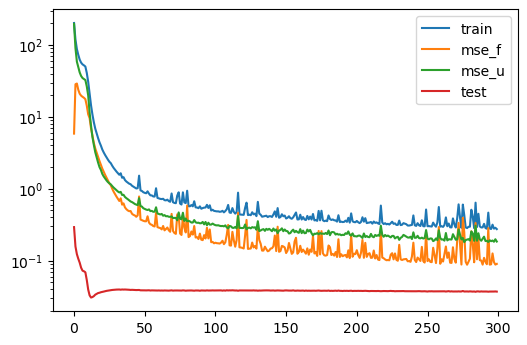

In [13]:
plt.figure(dpi=100)
plt.plot(train_error,label='train')
plt.plot(mse_fs,label='mse_f')
plt.plot(mse_us,label='mse_u')
plt.plot(test_error.cpu(),label='test')
plt.yscale('log')
plt.legend()
#plt.savefig('./figs/100kIters10kData10kCol.jpg')

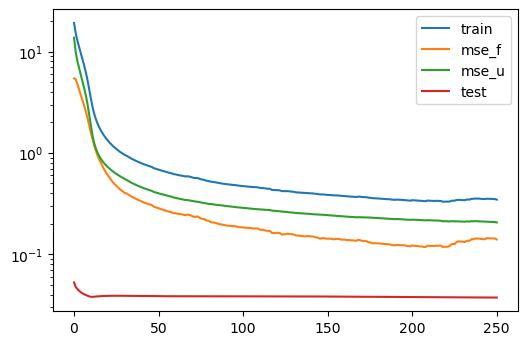

In [14]:
plt.figure(dpi=100)
plt.plot(running_mean(train_error),label='train')
plt.plot(running_mean(mse_fs),label='mse_f')
plt.plot(running_mean(mse_us),label='mse_u')
plt.plot(running_mean(test_error),label='test')
plt.yscale('log')
plt.legend()

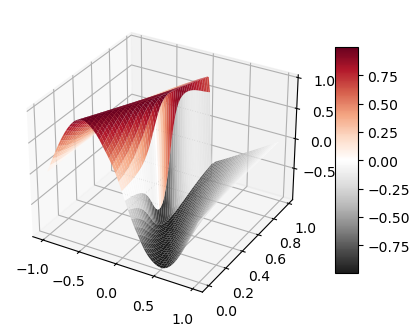

In [15]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

x1=np.arange(X_star.min(),X_star.max(),0.02)
x2=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x1, x2)
x1 = np.ravel(ms_x).reshape(-1,1)
x2 = np.ravel(ms_t).reshape(-1,1)

pt_x= torch.tensor(x1, requires_grad=True).float().to(device)
pt_t= torch.tensor(x2, requires_grad=True).float().to(device)
pt_u=model(torch.hstack([pt_x,pt_t]))
u=pt_u.detach().cpu().numpy()
ms_u = u.reshape(ms_x.shape)
pred_u=ms_u
surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.RdGy_r)
fig.colorbar(surf, shrink=.75, aspect=10)
plt.show()

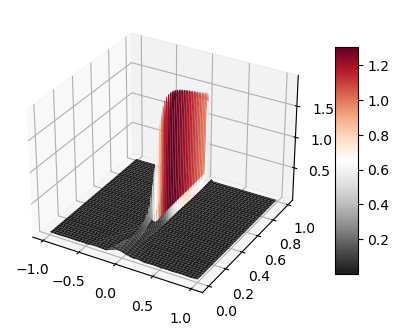

In [16]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

pt_u=model(torch.tensor(X_star).to(device))
ms_u = u_exact.reshape(X.shape)
pt_u=pt_u.reshape(X.shape)
surf = ax.plot_surface(X,T,(abs(ms_u-pt_u.detach().cpu().numpy())), cmap=cm.RdGy_r)
fig.colorbar(surf, shrink=.75, aspect=10)
plt.show()

Text(0.5, 1.0, '$t = 0.75$')

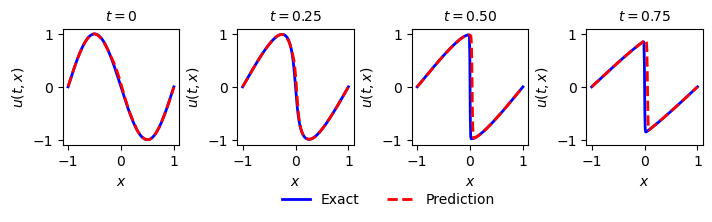

In [17]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

plt.figure(dpi=100,figsize=(8,10))
pred=model(torch.tensor(X_exact).to(device)).cpu().detach().numpy()
U_pred = griddata(X_exact, pred.flatten(), (X, T), method='cubic')


############################################################################
############################################################################
############################################################################


gs1 = gridspec.GridSpec(1, 4)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

x1 = torch.tensor(data['x'].flatten()).float()
ax = plt.subplot(gs1[0, 0])

ax.plot(x1,Exact[0,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x1,U_pred[0,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax = plt.subplot(gs1[0, 1])
ax.plot(x1,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x1,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 2])
ax.plot(x1,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x1,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)

ax.legend(loc='upper center', bbox_to_anchor=(-0.2, -0.3), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 3])
ax.plot(x1,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x1,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

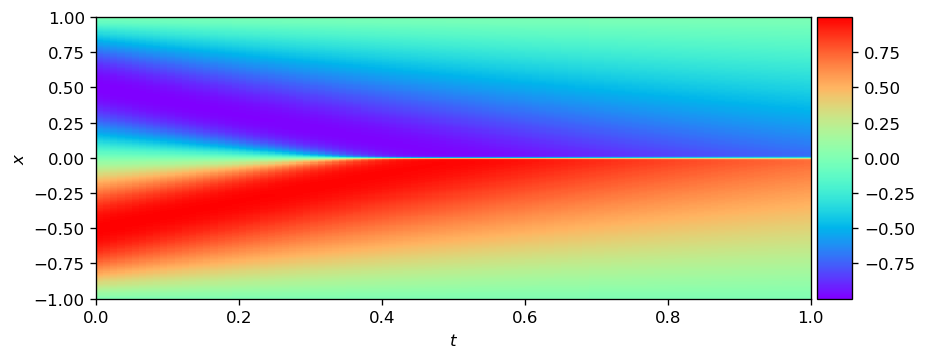

In [18]:
plt.figure(dpi=120,figsize=(9,11))
ax.axis('off')
U_pred = griddata(X_exact, pred.flatten(), (X, T), method='cubic')
U_star = griddata(X_exact, u_exact.flatten(), (X, T), method='nearest')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
#h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
#ax.set_title('u(t,x)', fontsize = 10)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
#ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)
#ax.plot(data_grid[:,1],data_grid[:,0], 'rx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)
plt.savefig('figs/zwischen/u(t,x).png',bbox_inches='tight',dpi=500)

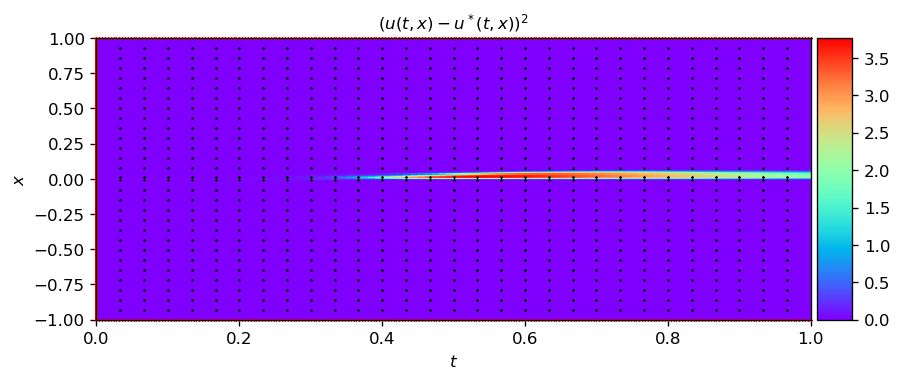

In [19]:
#absolute error
plt.figure(dpi=120,figsize=(9,11))
ax.axis('off')
pred=model(torch.tensor(X_exact).to(device)).cpu().detach().numpy()
U_pred = griddata(X_exact, pred.flatten(), (X, T), method='nearest')
U_star = griddata(X_exact, u_exact.flatten(), (X, T), method='nearest')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
U_diff= (np.square(U_pred-U_star))
h = ax.imshow(U_diff.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$(u(t,x)-u^*(t,x))^2$', fontsize = 10)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)
ax.plot(data_grid[:,1],data_grid[:,0], 'rx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)
#plt.savefig('figs/u(t,x)diff_t.jpg',bbox_inches='tight',dpi=500)

In [20]:
'''
n_epochs=1000

la = laplace.Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure='full')
#la = laplace.Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure='full')
tloader=loader(x,t,u_star)
la.fit(tloader)
#
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

X_test=X_star
f_mu, f_var = la(torch.as_tensor(X_test).requires_grad_().to(device))
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)
plot_burger(pred_std)
'''

"\nn_epochs=1000\n\nla = laplace.Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure='full')\n#la = laplace.Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure='full')\ntloader=loader(x,t,u_star)\nla.fit(tloader)\n#\nlog_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)\nhyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)\nfor i in range(n_epochs):\n    hyper_optimizer.zero_grad()\n    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())\n    neg_marglik.backward()\n    hyper_optimizer.step()\n\nX_test=X_star\nf_mu, f_var = la(torch.as_tensor(X_test).requires_grad_().to(device))\nf_mu = f_mu.squeeze().detach().cpu().numpy()\nf_sigma = f_var.squeeze().sqrt().cpu().numpy()\npred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)\nplot_burger(pred_std)\n"

In [21]:
def loss_fn_Jac(outputs,targets):
    return outputs[:, 0].sum()
def _flatten_after_batch(tensor: torch.Tensor):
    if tensor.ndim == 1:
        return tensor.unsqueeze(-1)
    else:
        return tensor.flatten(start_dim=1)
def _get_batch_grad(model):
    batch_grads = list()
    for module in model.modules():
        if hasattr(module, 'op_results'):
            res = module.op_results['batch_grads']
            if 'weight' in res:
                batch_grads.append(_flatten_after_batch(res['weight']))
            if 'bias' in res:
                batch_grads.append(_flatten_after_batch(res['bias']))
            if len(set(res.keys()) - {'weight', 'bias'}) > 0:
                raise ValueError(f'Invalid parameter keys {res.keys()}')
    return torch.cat(batch_grads, dim=1)

In [22]:
def batch_gradient(model, loss_fn, X, targets,Functional=None):
    with asdfghjkl.extend(model, 'batch_grads'):
        model.zero_grad()
        if Functional:
            f=Functional(X[:,0,None],X[:,1,None],model)
        else:
            f = model(X)
        loss = loss_fn(f, targets)
        loss.backward()
    return f

In [23]:
from asdfghjkl import SHAPE_KRON, SHAPE_DIAG, SHAPE_FULL
def asdl_hessian(model, loss,X,y,Functional=None):
    params = [p for p in model.parameters() if p.requires_grad]
    if Functional:
        output=Functional(X[:,0,None],X[:,1,None],model)
    else:
        output=model(X)
    loss=loss(output,y)
    return loss.detach(),asdfghjkl.hessian(loss,params)

In [24]:
X_f=dots

In [25]:
lossfunc=torch.nn.MSELoss(reduction='sum')
loss_f,H_f=asdl_hessian(model,lossfunc,X_f,torch.zeros(X_f.shape[0],1).to(device),f_u)
H_f

tensor([[ 6.0589e+01,  2.4271e+02,  4.5287e+01,  ...,  6.0267e+01,
         -2.0266e+00,  9.0633e+01],
        [ 2.4271e+02,  2.3352e+03,  1.8639e+02,  ...,  7.4460e+02,
         -7.7475e+02,  1.8746e+03],
        [ 4.5287e+01,  1.8639e+02,  9.0912e+01,  ...,  1.3852e+02,
         -2.4079e+02,  4.0759e+02],
        ...,
        [ 6.0267e+01,  7.4460e+02,  1.3852e+02,  ...,  4.8032e+03,
         -1.5840e+03,  6.0519e+03],
        [-2.0266e+00, -7.7475e+02, -2.4079e+02,  ..., -1.5840e+03,
          2.2589e+03, -4.0798e+03],
        [ 9.0633e+01,  1.8746e+03,  4.0759e+02,  ...,  6.0519e+03,
         -4.0798e+03,  1.1259e+04]], device='cuda:0')

In [26]:
lossfunc=torch.nn.MSELoss(reduction='mean')
loss_f,H_f2=asdl_hessian(model,lossfunc,X_f,torch.zeros(X_f.shape[0],1).to(device),f_u)
H_f2*dots.shape[0]

tensor([[ 6.0589e+01,  2.4271e+02,  4.5287e+01,  ...,  6.0267e+01,
         -2.0266e+00,  9.0633e+01],
        [ 2.4271e+02,  2.3352e+03,  1.8639e+02,  ...,  7.4460e+02,
         -7.7475e+02,  1.8746e+03],
        [ 4.5287e+01,  1.8639e+02,  9.0912e+01,  ...,  1.3852e+02,
         -2.4079e+02,  4.0759e+02],
        ...,
        [ 6.0267e+01,  7.4460e+02,  1.3852e+02,  ...,  4.8032e+03,
         -1.5840e+03,  6.0519e+03],
        [-2.0266e+00, -7.7475e+02, -2.4079e+02,  ..., -1.5840e+03,
          2.2589e+03, -4.0798e+03],
        [ 9.0633e+01,  1.8746e+03,  4.0759e+02,  ...,  6.0519e+03,
         -4.0798e+03,  1.1259e+04]], device='cuda:0')

In [27]:
def cho_inverse(A):
    cho=torch.linalg.cholesky(A)
    inv=torch.cholesky_inverse(cho)
    return inv@inv.T

In [28]:
c_inv=cho_inverse(H_f2+10*torch.eye(H_f.shape[0],device=device)).cpu()

In [29]:
p_inv=torch.linalg.pinv(H_f+10*torch.eye(H_f.shape[0],device=device)).cpu()

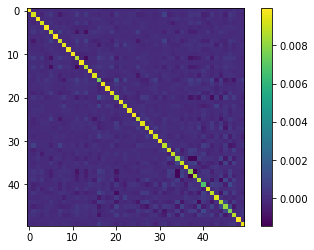

In [30]:
plt.imshow((c_inv-p_inv)[:50,:50])
plt.colorbar()

In [31]:
np.linalg.norm(c_inv-p_inv)/np.prod(c_inv.shape)

3.86322281456622e-07

In [32]:
from functools import reduce
from laplace.utils import FeatureExtractor
from copy import deepcopy
from torch.nn.utils import parameters_to_vector

'''
from backpack import backpack, extend, memory_cleanup
from backpack.extensions import DiagGGNExact, DiagGGNMC, KFAC, KFLR, SumGradSquared, BatchGrad
from backpack.context import CTX
'''
from torch.distributions.multivariate_normal import _precision_to_scale_tril


#hardcode lastlayer full laplace with hyper optim
class Laplace_s3:
    def __init__(self,model, X_f,X_b,optim=True,Epochs=100,use_fisher=False,use_pinv=False,REDUCTION='mean'):

        ###constructor
        self.use_fisher=use_fisher
        self.model=model
        #self.sigma_noise=1
        self._device = next(model.parameters()).device
        self.prior_precision = 1.
        self.prior_mean = 0.
        self.mean = self.prior_mean
        self.observation_noise=0
        #all training inputs
        X=torch.vstack([X_f,X_b])
        self.n_data=len(X)
        self.params = [p for p in model.parameters() if p.requires_grad]
        self.n_params=len(torch.cat([p.flatten() for p in model.parameters() if p.requires_grad]))
        ###fit 
        self.model.eval()
        self.mean = parameters_to_vector(self.model.parameters()).detach()

        with torch.no_grad():
            try:
                out = self.model(X[:1].to(self._device))
            except (TypeError, AttributeError):
                out = self.model(X.to(self._device))
        self.n_outputs = out.shape[-1]
        setattr(self.model, 'output_size', self.n_outputs)

        ##"Loader Loop"
        print('Fitting')
        self.model.zero_grad()
        X_b, X_f  = X_b.to(self._device), X_f.to(self._device)
        #use fisher approximation for hessian
        lossfunc=torch.nn.MSELoss(reduction=REDUCTION)
        self.factor=.5
        if use_fisher:
            batch_gradient(model,loss_fn_Jac,X_f,None,f_u)
            Js_f=_get_batch_grad(model)
            Js_f=Js_f.view(Js_f.shape[0],1,-1)
            batch_gradient(model,loss_fn_Jac,X_b,None,b_u)
            Js_b=_get_batch_grad(model)
            Js_b=Js_b.view(Js_b.shape[0],1,-1)
            fs=f_u(X_f[:,0,None].requires_grad_(),X_f[:,1,None].requires_grad_(),model)
            bs=b_u(X_b[:,0,None].requires_grad_(),X_b[:,1,None].requires_grad_(),model)
            loss_f = lossfunc(fs, torch.zeros_like(fs))
            loss_b = lossfunc(bs, torch.zeros_like(bs))
            self.H_f = torch.einsum('mkp,mkq->pq', Js_f, Js_f).detach()
            self.H_b = torch.einsum('mkp,mkq->pq', Js_b, Js_b).detach()
        #use full hessian
        else:
            loss_f,H_f=asdl_hessian(model,lossfunc,X_f,torch.zeros(X_f.shape[0],1).to(self._device),f_u)
            loss_b,H_b=asdl_hessian(model,lossfunc,X_b,torch.zeros(X_b.shape[0],1).to(self._device),b_u)
            self.H_f=self.factor*H_f.detach()
            self.H_b=self.factor*H_b.detach()

        
        ###
        self.loss_f=self.factor*loss_f.detach()
        self.loss_b=self.factor*loss_b.detach()
        self.loss=torch.add(self.loss_f,self.loss_b)
        self.H = self.H_f.detach() + self.H_b.detach()

        #print('\nHERE\n','loss f',self.loss_f,'loss b',self.loss_b,'\n H_f',self.H_f,'\n H_b',self.H_b)

        ###hyper optim
        if optim:

            margliks=[]
            liks=[]
            posterior_precision_mean=[]
            num_eigs=[]
            eigs=[]
            log_priors=[]
            log_sigmas=[]
            log_sigmas_f=[]
            log_sigmas_b=[]
            cs=[]
            det_ratios=[]
            post_dets=[]
            prior_dets=[]
            loss_fs=[]

            print('Hyperparameter optim')
            epochs=Epochs
            #initialize prior hyperparams
            log_prior = torch.ones(1, requires_grad=True,device=self._device)
            log_sigma_f, log_sigma_b=torch.ones(1, requires_grad=True,device=self._device), torch.ones(1, requires_grad=True,device=self._device)
            hyper_optimizer = torch.optim.Adam([log_prior, log_sigma_f,log_sigma_b], lr=1e-2)
            self.posterior_precision=self.H + torch.diag(1.0*torch.ones(self.n_params, device=self._device))
            for i in range(epochs):
                hyper_optimizer.zero_grad()
                self.sigma_f=log_sigma_f.exp()#.requires_grad_().to(self._device)
                self.sigma_b=log_sigma_b.exp()#.requires_grad_().to(self._device)

                self.prior_precision=log_prior.exp()
                c=len(X_f) * torch.log(self.sigma_f*np.sqrt(2*np.pi)) + len(X_b) * torch.log(self.sigma_b*np.sqrt(2*np.pi))
                #experiment unscaled c
                #c= torch.log(self.sigma_f*np.sqrt(2*np.pi)) +  torch.log(self.sigma_b*np.sqrt(2*np.pi))
                H_factor_f=  1 / (self.sigma_f.square())
                H_factor_b=  1 / (self.sigma_b.square())

                H_f_scale=len(X_f)
                H_b_scale=len(X_b)
                self.log_likelihood= -H_factor_f *H_f_scale * self.loss_f - H_factor_b*H_b_scale *self.loss_b - c

                #self.posterior_precision=H_factor*self.H + torch.diag(self.prior_precision * torch.ones(self.n_params, device=self._device))
                self.posterior_precision=((H_factor_f*self.H_f + H_factor_b*self.H_b) + torch.diag(self.prior_precision * torch.ones(self.n_params, device=self._device)))
                self.post_det=self.posterior_precision.slogdet()[1]
                self.prior_det=(self.prior_precision * torch.ones(self.n_params, device=self._device)).log().sum()
                self.log_det_ratio =  self.post_det - self.prior_det

                #debug self mean and self prior mean, not sure they make sense rn
                #self.prior_mean=self.prior_precision*torch.ones_like(self.mean)
                self.prior_mean=0*torch.ones_like(self.mean)
                delta = (self.mean - self.prior_mean)
                self.scatter= (delta * self.prior_precision) @ delta

                #neg_marglik= -(self.log_likelihood - 0.5 * (self.log_det_ratio + self.scatter))
                #no scatter
                neg_marglik= -(self.log_likelihood - 0.5 * (self.log_det_ratio))# + self.scatter))

                det_ratios.append(self.log_det_ratio.cpu().detach())
                margliks.append(neg_marglik.cpu().detach())
                liks.append(self.log_likelihood.cpu().detach())
                posterior_precision_mean.append(self.posterior_precision.mean().cpu().detach())
                num_eigs.append(torch.count_nonzero(torch.linalg.eigvalsh(self.posterior_precision)<0).cpu())
                eigs.append(torch.linalg.eigvalsh(self.posterior_precision).detach().cpu()[0])
                log_priors.append(log_prior.exp().cpu().detach())
                log_sigmas.append(self.sigma_f.cpu().detach())
                log_sigmas_b.append(self.sigma_b.cpu().detach())
                post_dets.append(self.post_det.cpu().detach())
                prior_dets.append(self.prior_det.cpu().detach())
                cs.append(c.cpu().detach())
                loss_fs.append((H_factor_f  * self.loss_f).cpu().detach())

                neg_marglik.backward()
                hyper_optimizer.step() 


            plt.plot(margliks)
            plt.title('neg marglik')
            plt.show()
            plt.plot(liks)
            plt.title('loglikelihood')
            plt.show()
            plt.plot(posterior_precision_mean)
            plt.title('posterior_precision_mean')
            plt.show()
            plt.plot(cs)
            plt.title('cs')
            plt.show()
            plt.plot(num_eigs)
            plt.title('number of negative eigs')
            plt.show()
            plt.plot(eigs)
            plt.title('Smallest eig')
            plt.show()
            plt.plot(log_priors)
            plt.title('priors')
            plt.show()
            plt.plot(log_sigmas)
            plt.yscale('log')
            plt.title('sigmas_f')
            plt.show()
            plt.plot(log_sigmas_b)
            plt.yscale('log')
            plt.title('sigmas_b')
            plt.show()
            plt.plot(det_ratios)
            plt.title('det ratio')
            plt.show()
            '''
            plt.plot(prior_dets)
            plt.title('prior_det')
            plt.show()
            plt.plot(post_dets)
            plt.title('post_det')
            plt.show()
            '''
            plt.plot(np.multiply(loss_fs ,len(X_f)))
            plt.yscale('log')
            plt.title('scaled loss')
            plt.show()

            self.prior_precision = log_prior.detach().exp()
            #self.posterior_precision=H_factor*self.H + torch.diag(self.prior_precision * torch.ones(self.n_params, device=self._device))
            print(self.posterior_precision)
            print('Eigs:',torch.linalg.eigvalsh(self.posterior_precision))
            print('Any infs:',torch.any(torch.isinf(self.posterior_precision)),'\n Any nans:',torch.any(torch.isnan(self.posterior_precision)))
            print('det:',torch.det(self.posterior_precision))
            if use_pinv:
                self.posterior_covariance=torch.linalg.pinv(self.posterior_precision)
            else:
                chol=torch.linalg.cholesky(self.posterior_precision)
                inv=torch.cholesky_inverse(chol)
                self.posterior_covariance=inv@inv.T
    def __call__(self,X):
        print('Call')
        f_mu=self.model(X.to(self._device))
        #Calculate Jacobian of eval data
        asdfghjkl.batch_gradient(model,loss_fn_Jac,torch.as_tensor(X).requires_grad_().to(device),None)
        Js=_get_batch_grad(model)
        Js=Js.view(Js.shape[0],1,-1)
        f_var= torch.einsum('ncp,pq,nkq->nck', Js, self.posterior_covariance, Js)
        return f_mu,f_var


Fitting
Hyperparameter optim


c:\Users\thoma\anaconda3\envs\gym_3\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\thoma\anaconda3\envs\gym_3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


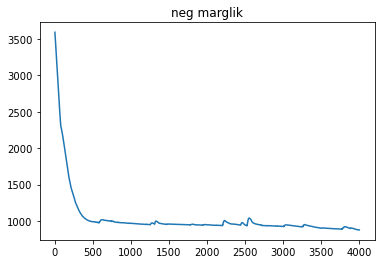

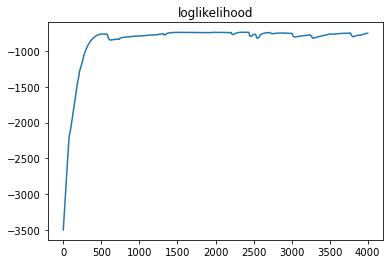

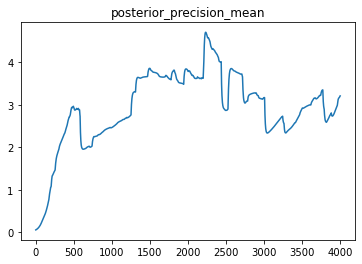

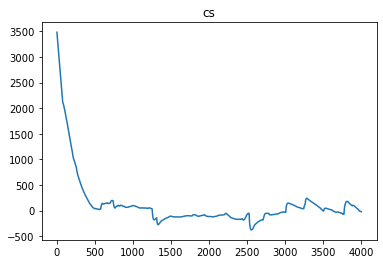

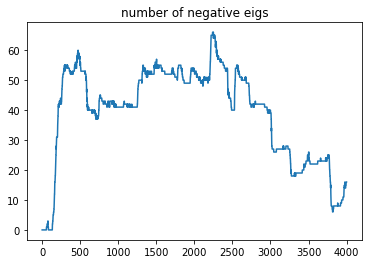

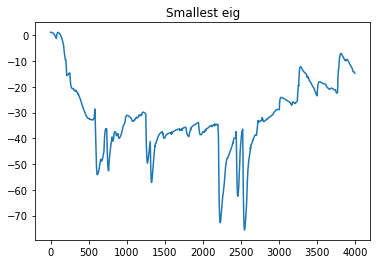

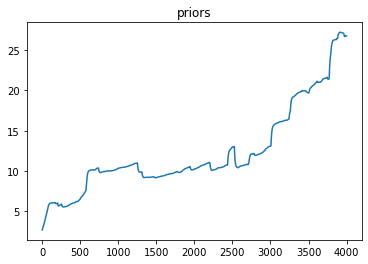

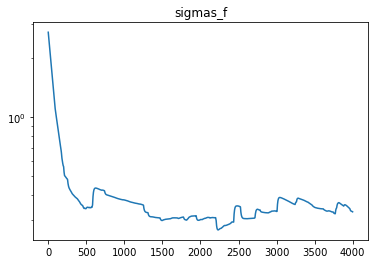

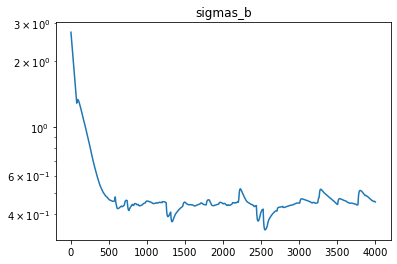

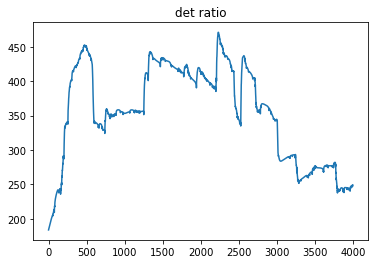

C:\Users\thoma\AppData\Local\Temp\ipykernel_5128\2669436973.py:195: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.plot(np.multiply(loss_fs ,len(X_f)))
C:\Users\thoma\AppData\Local\Temp\ipykernel_5128\2669436973.py:195: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.multiply(loss_fs ,len(X_f)))


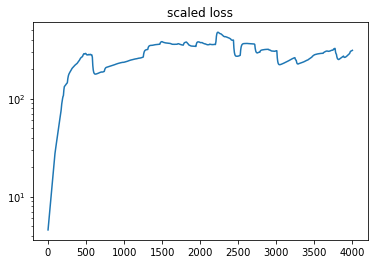

tensor([[ 6.5476e+02,  1.1581e+03,  4.5283e+02,  ...,  1.3992e+02,
         -3.4653e+01,  6.2285e+02],
        [ 1.1581e+03,  1.0825e+04,  8.4563e+02,  ...,  3.4772e+03,
         -3.7199e+03,  8.9255e+03],
        [ 4.5283e+02,  8.4563e+02,  8.6593e+02,  ...,  3.2625e+02,
         -7.5923e+02,  1.2736e+03],
        ...,
        [ 1.3992e+02,  3.4772e+03,  3.2625e+02,  ...,  2.3096e+04,
         -8.0722e+03,  2.9666e+04],
        [-3.4653e+01, -3.7199e+03, -7.5923e+02,  ..., -8.0722e+03,
          1.1549e+04, -2.0967e+04],
        [ 6.2285e+02,  8.9255e+03,  1.2736e+03,  ...,  2.9666e+04,
         -2.0967e+04,  5.6718e+04]], device='cuda:0', grad_fn=<AddBackward0>)
Eigs: tensor([-1.4689e+01, -1.4604e+01, -1.1981e+01, -1.1171e+01, -1.0528e+01,
        -7.7993e+00, -5.8542e+00, -5.5442e+00, -3.5383e+00, -3.4260e+00,
        -2.5284e+00, -2.1683e+00, -1.8385e+00, -1.6497e+00, -3.7854e-01,
        -1.9359e-01,  1.7028e-01,  3.6802e-01,  1.3871e+00,  2.7357e+00,
         2.9261e+00,  3.8328e

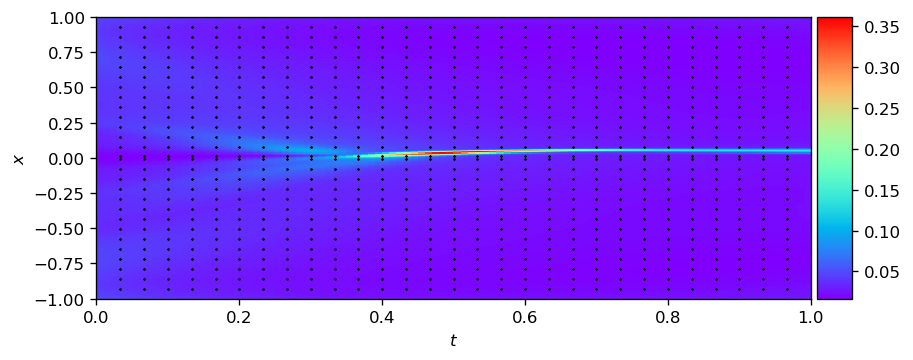

In [33]:
lala=Laplace_s3(model,dots,data_grid_used,optim=True,Epochs=4000,use_pinv=True,REDUCTION='sum')
e,e_var=lala(torch.as_tensor(X_star).requires_grad_())
e = e.squeeze().detach().cpu().numpy()
e_sig = e_var.squeeze().sqrt().detach().cpu().numpy()
#U_std
plot_burger(e_sig)

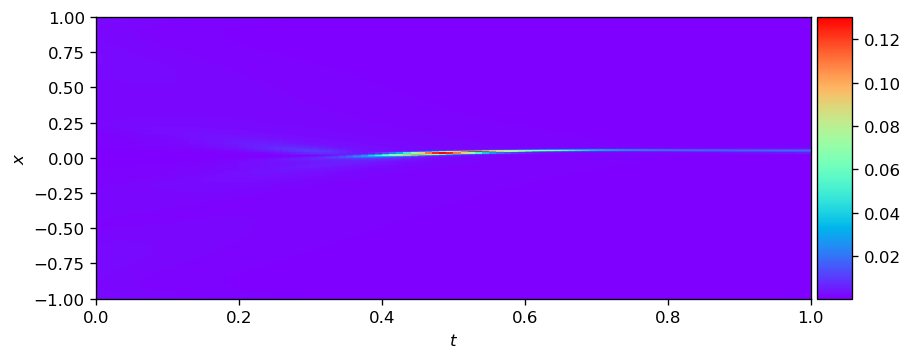

In [34]:
plot_burger(e_var.cpu().detach(),0)

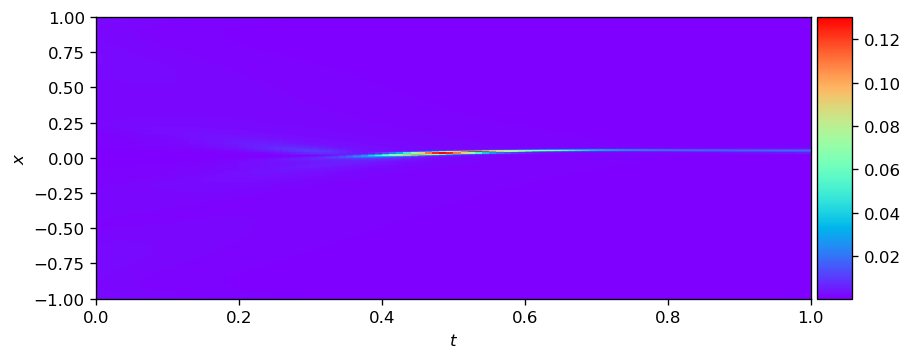

In [35]:
plot_burger(e_sig**2,0)

In [36]:
'''
lala=Laplace_s3(model,dots,data_grid_used,use_fisher=True,use_pinv=True,Epochs=2000,optim=True,REDUCTION='sum')
e,e_var=lala(torch.as_tensor(X_star).requires_grad_())
e = e.squeeze().detach().cpu().numpy()
e_sig = e_var.squeeze().sqrt().detach().cpu().numpy()
#U_std
plot_burger(e_sig)
'''



"\nlala=Laplace_s3(model,dots,data_grid_used,use_fisher=True,use_pinv=True,Epochs=2000,optim=True,REDUCTION='sum')\ne,e_var=lala(torch.as_tensor(X_star).requires_grad_())\ne = e.squeeze().detach().cpu().numpy()\ne_sig = e_var.squeeze().sqrt().detach().cpu().numpy()\n#U_std\nplot_burger(e_sig)\n"

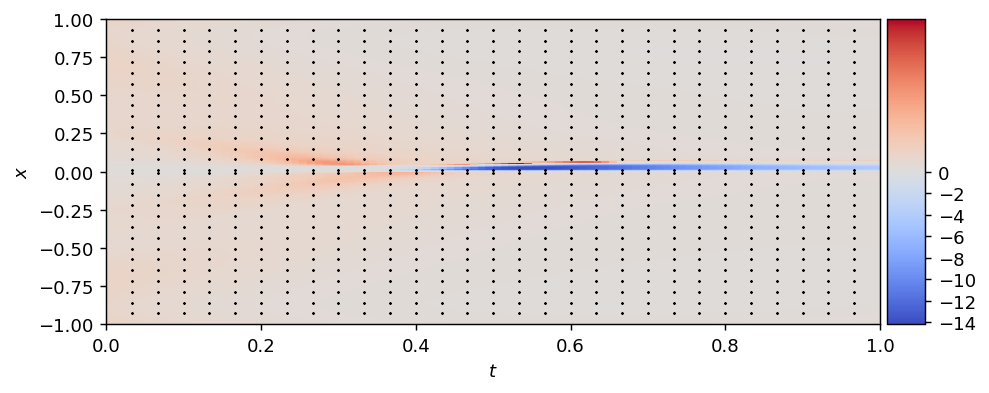

In [37]:

divnorm=colors.TwoSlopeNorm(vcenter=0.)
plt.figure(dpi=130,figsize=(9,11))
U_std = griddata(X_exact, e_sig.flatten(), (X, T), method='cubic')
U_var = griddata(X_exact, e_var.flatten().detach().cpu(), (X, T), method='nearest')
U_mu = griddata(X_exact, e.flatten(), (X, T), method='cubic')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(((U_var)-U_diff**2).T, interpolation='nearest',norm=divnorm, cmap='coolwarm', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)

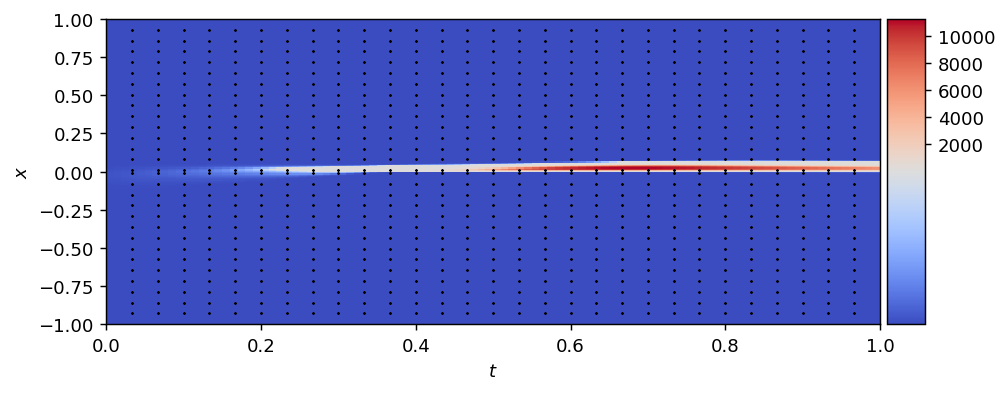

In [38]:
#squared error over variance
divnorm=colors.TwoSlopeNorm(vcenter=1.)
plt.figure(dpi=130,figsize=(9,11))
U_var = griddata(X_exact, e_var.flatten().detach().cpu(), (X, T), method='nearest')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow((((U_diff)**2)/U_var).T, interpolation='nearest',norm=divnorm, cmap='coolwarm', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)

In [39]:
print((U_diff**2/U_var).min(),(U_diff**2/U_var).mean(),(U_diff**2/U_var).max())

1.4783460996378625e-27 61.72489037150977 11237.986158201316


# Confidence Interval

In [40]:
from scipy.stats import chi2
alpha=.05
c1,c2=chi2.ppf([alpha/2,1-alpha/2],1)
print(c1,c2)
chi2.interval(1-alpha,1)

0.0009820691171752555 5.023886187314888


(0.0009820691171752583, 5.023886187314888)

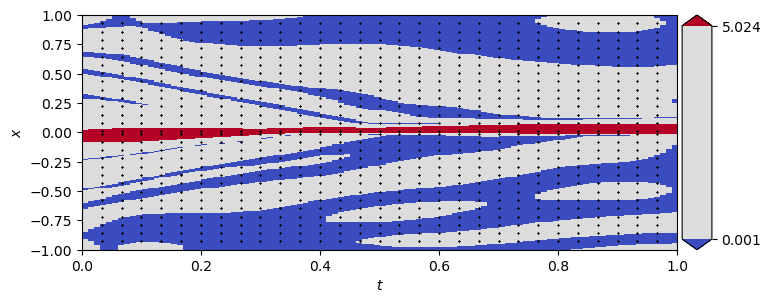

In [41]:
from scipy.stats import chi2
alpha=.05
c1,c2=chi2.ppf([alpha/2,1-alpha/2],1)
bounds = [c1,c2]
divnorm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
plt.figure(dpi=100,figsize=(9,11))
U_var = griddata(X_exact, e_var.flatten().detach().cpu(), (X, T), method='nearest')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow((((U_diff))/(U_var)).T, interpolation='nearest',norm=divnorm, cmap='coolwarm', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)

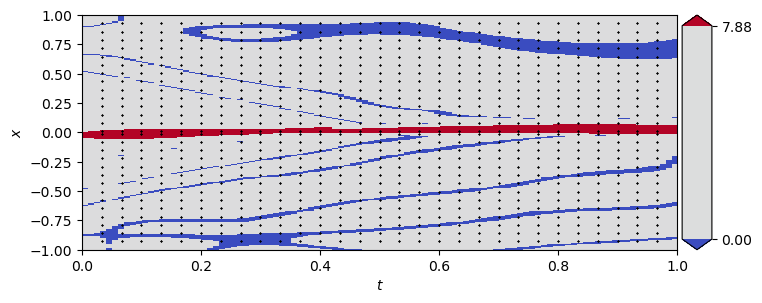

In [42]:

from scipy.stats import chi2
alpha=.01
c1,c2=chi2.ppf([alpha/2,1-alpha/2],1)
bounds = [c1,c2]
divnorm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
plt.figure(dpi=100,figsize=(9,11))
U_var = griddata(X_exact, e_var.flatten().detach().cpu(), (X, T), method='nearest')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow((((U_diff))/(U_var)).T, interpolation='nearest',norm=divnorm, cmap='coolwarm', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)

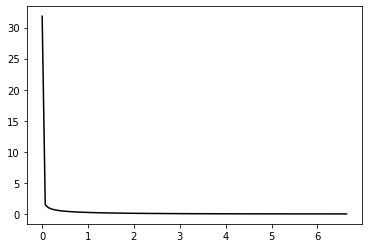

In [43]:
xs= np.linspace(chi2.ppf(0.01, 1),chi2.ppf(0.99,1), 100)
rv = chi2(1)
plt.plot(xs, rv.pdf(xs), 'k-',  label='frozen pdf')

In [44]:
def get_area(diff,level):
    x1,x2=chi2.interval(level,1)
    lower=len(np.where(diff<x1)[0])
    upper=len(np.where(diff>x2)[0])
    return (lower+upper)/np.prod(diff.shape)

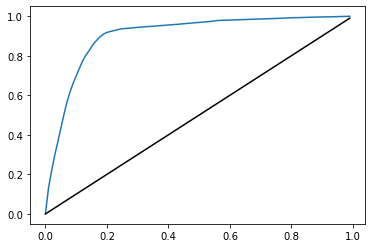

In [45]:
quantiles=[.01*i for i in range(100)]
emp=[get_area(U_diff/U_var,1-q)for q in quantiles]
plt.plot(quantiles,emp)
plt.plot(quantiles,quantiles,'k')

In [46]:
S_eig,U_eig=torch.linalg.eig(lala.posterior_precision)#.float()
U_eig=U_eig.float()
S_eig=S_eig.float()

C:\Users\thoma\AppData\Local\Temp\ipykernel_5128\1868347620.py:2: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:250.)
  U_eig=U_eig.float()


In [47]:
Xss=torch.as_tensor(X_star).requires_grad_()
asdfghjkl.batch_gradient(model,loss_fn_Jac,torch.as_tensor(Xss).requires_grad_().to(device),None)
Js=_get_batch_grad(model)
#Js=Js.view(Js.shape[0],1,-1)I

In [48]:
S_eig,U_eig=torch.linalg.eig(lala.posterior_precision)#.float()
U_eig=U_eig.float()
S_eig=S_eig.float()
Xss=torch.as_tensor(X_star).requires_grad_()
asdfghjkl.batch_gradient(model,loss_fn_Jac,torch.as_tensor(Xss).requires_grad_().to(device),None)
Js=_get_batch_grad(model)
eigfunc=(Js@U_eig@torch.diag(S_eig.sqrt())).cpu().detach()

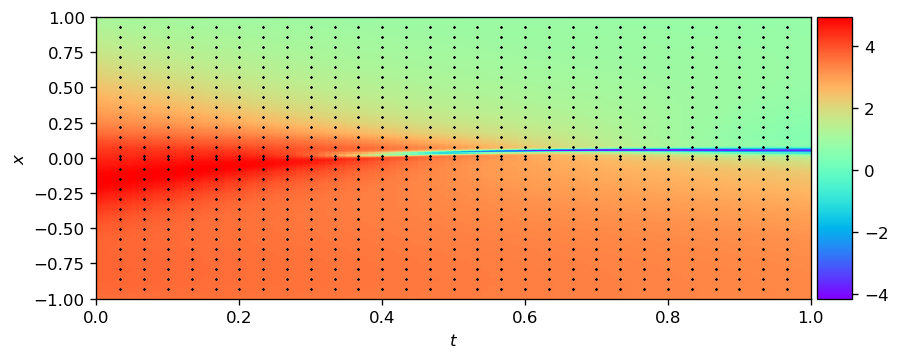

In [49]:
plot_burger((Js@U_eig)[:,0].cpu().detach())

In [78]:
%matplotlib qt
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


S_eig,U_eig=torch.linalg.eig(lala.posterior_precision)#.float()
U_eig=U_eig.float()
S_eig=S_eig.float()
Xss=torch.as_tensor(X_star).requires_grad_()
asdfghjkl.batch_gradient(model,loss_fn_Jac,torch.as_tensor(Xss).requires_grad_().to(device),None)
Js=_get_batch_grad(model)
eigfunc=(Js@U_eig@torch.diag(S_eig.sqrt())).cpu().detach()
#eigfunc=(Js@U_eig).cpu().detach()
max_freq=eigfunc.shape[-1]

# The parametrized function to be plotted
def im(x):
    U_std = griddata(X_exact, eigfunc[:,x].flatten(), (X, T), method='nearest')
    return U_std.T

# Define initial parameters
init_frequency = 0

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(figsize=(19,9),dpi=80)
h=ax.imshow(im(0), interpolation='nearest', cmap='rainbow', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
ax.set_xlabel('Time [s]')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)


ax.plot(t_col.detach().cpu(),x_col.detach().cpu(), 'kx', label = 'Data (%d points)' % (u_star.shape[0]), markersize = 1, clip_on = False)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])

steps=[i for i in range(max_freq)]

freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0,
    valstep=steps,
    valmax=max_freq,
    valinit=init_frequency,
)

# The function to be called anytime a slider's value changes
def update(val):
    #line.set_ydata(f(freq_slider.val))
    h=ax.imshow(im(val), interpolation='nearest', cmap='rainbow', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
    plt.colorbar(h,cax=cax)
    fig.canvas.draw_idle()



# register the update function with each slider
freq_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.045, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

prevax = fig.add_axes([0.7, 0.025, 0.045, 0.04])
nextax = fig.add_axes([0.75, 0.025, 0.045, 0.04])
prevbutton = Button(prevax, 'prev', hovercolor='0.975')
nextbutton = Button(nextax, 'next', hovercolor='0.975')

def next(e):
    freq_slider.set_val(freq_slider.val+1)
nextbutton.on_clicked(next)
def prev(e):
    freq_slider.set_val(freq_slider.val-1)
prevbutton.on_clicked(prev)


def reset(event):
    freq_slider.reset()
button.on_clicked(reset)



plt.show()

In [51]:
%matplotlib inline